In [1]:
# Logistic Regression mit PhiUSIIL Dataset

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from ucimlrepo import fetch_ucirepo
from benchmark import PerformanceMonitor

import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

def ClassPrintMetrics(y_real, y_pred):
    confusion_matrix = metrics.confusion_matrix(y_real, y_pred)
    # y_real muss sicherstellen, dass es Strings oder Ints für die Labels sind
    y_real_labels = list(map(str, sorted(y_real.unique().tolist())))
    
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=y_real_labels)
    disp.plot()
    print(metrics.classification_report(y_real, y_pred))

# --- NEUER TEIL: PhiUSIIL DATENSATZ LADEN ---
print("Lade PhiUSIIL Phishing URL Dataset von UCI...")
phiusiil_phishing_url = fetch_ucirepo(id=967) 
  
# Features und Targets holen
X = phiusiil_phishing_url.data.features 
y = phiusiil_phishing_url.data.targets 
  
# Zusammenführen in einen DataFrame 'dataset'
dataset = pd.concat([X, y], axis=1)

# Bereinigung: Falls 'URL' als Textspalte existiert, müssen wir sie für die Regression entfernen,
# da LogisticRegression nur Zahlen verarbeitet.
if 'URL' in dataset.columns:
    dataset = dataset.drop(columns=['URL'])

# Das UCI Dataset nennt das Target meist 'label' (0 = Legitimate, 1 = Phishing).
# Ihr Code erwartet aber die Spalte "Phishing?". Wir benennen sie um.
# Prüfen, wie die Target-Spalte heißt (meistens 'label' bei diesem Set)
target_col = y.columns[0]
dataset.rename(columns={target_col: 'Phishing?'}, inplace=True)

# Sicherstellen, dass alles numerisch ist (Fehlerbehandlung für Strings)
dataset = dataset.select_dtypes(include=[np.number])

print("Datensatz geladen. Spalten:")
print(dataset.columns.tolist())


f:\GitHub Repositorys\Evaluation_of_AI_Models\.venv\Lib\site-packages\torch\cuda\__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


Lade PhiUSIIL Phishing URL Dataset von UCI...
Datensatz geladen. Spalten:
['URLLength', 'DomainLength', 'IsDomainIP', 'URLSimilarityIndex', 'CharContinuationRate', 'TLDLegitimateProb', 'URLCharProb', 'TLDLength', 'NoOfSubDomain', 'HasObfuscation', 'NoOfObfuscatedChar', 'ObfuscationRatio', 'NoOfLettersInURL', 'LetterRatioInURL', 'NoOfDegitsInURL', 'DegitRatioInURL', 'NoOfEqualsInURL', 'NoOfQMarkInURL', 'NoOfAmpersandInURL', 'NoOfOtherSpecialCharsInURL', 'SpacialCharRatioInURL', 'IsHTTPS', 'LineOfCode', 'LargestLineLength', 'HasTitle', 'DomainTitleMatchScore', 'URLTitleMatchScore', 'HasFavicon', 'Robots', 'IsResponsive', 'NoOfURLRedirect', 'NoOfSelfRedirect', 'HasDescription', 'NoOfPopup', 'NoOfiFrame', 'HasExternalFormSubmit', 'HasSocialNet', 'HasSubmitButton', 'HasHiddenFields', 'HasPasswordField', 'Bank', 'Pay', 'Crypto', 'HasCopyrightInfo', 'NoOfImage', 'NoOfCSS', 'NoOfJS', 'NoOfSelfRef', 'NoOfEmptyRef', 'NoOfExternalRef', 'Phishing?']


In [2]:
def get_imbalanced_test_split(X, y, test_phish_count=50, ratio=1000, seed=42):
    """
    Creates a custom train/test split with a fixed ratio of 1000:1 (Legit:Phish) in the test set.
    
    Args:
        X: Features (Dataframe, Series, or List)
        y: Labels (Dataframe, Series, or List/Array)
        test_phish_count: How many phishing URLs to put in the Test Set.
        ratio: How many legitimate URLs per phishing URL (default 1000).
        seed: Random seed for reproducibility.
    """
    np.random.seed(seed)
    
    # Ensure inputs are standard format (Pandas Series or Numpy Array) for indexing
    if isinstance(X, list): X = np.array(X)
    if isinstance(y, list): y = np.array(y)
    
    # If X/y are DataFrames, extract the underlying array/series
    if isinstance(y, pd.DataFrame): y = y.iloc[:, 0]
    
    # Identify indices
    # We assume Label 1 = Phishing, Label 0 = Legitimate
    phish_indices = np.where(y == 1)[0]
    legit_indices = np.where(y == 0)[0]
    
    # Calculate Test Sizes
    n_test_phish = test_phish_count
    n_test_legit = test_phish_count * ratio
    
    # Checks
    if len(phish_indices) < n_test_phish:
        raise ValueError(f"Not enough Phishing samples. Have {len(phish_indices)}, need {n_test_phish}")
    if len(legit_indices) < n_test_legit:
        raise ValueError(f"Not enough Legitimate samples. Have {len(legit_indices)}, need {n_test_legit}")
        
    print(f"Creating 1000:1 Test Split...")
    print(f"Test Set: {n_test_phish} Phishing, {n_test_legit} Legitimate (Total: {n_test_phish + n_test_legit})")
    
    # Shuffle indices
    np.random.shuffle(phish_indices)
    np.random.shuffle(legit_indices)
    
    # Select Indices for Test
    test_idx_phish = phish_indices[:n_test_phish]
    test_idx_legit = legit_indices[:n_test_legit]
    test_indices = np.concatenate([test_idx_phish, test_idx_legit])
    np.random.shuffle(test_indices) # Shuffle the test set itself
    
    # Select Indices for Train (The Rest)
    train_idx_phish = phish_indices[n_test_phish:]
    train_idx_legit = legit_indices[n_test_legit:]
    train_indices = np.concatenate([train_idx_phish, train_idx_legit])
    np.random.shuffle(train_indices) # Shuffle the train set
    
    # Perform Split
    # Handle pandas vs numpy indexing
    if isinstance(X, (pd.DataFrame, pd.Series)):
        X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
        y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]
    else:
        X_train, X_test = X[train_indices], X[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]
        
    return X_train, X_test, y_train, y_test

Phishing?
1    134850
0    100945
Name: count, dtype: int64

<Axes: >

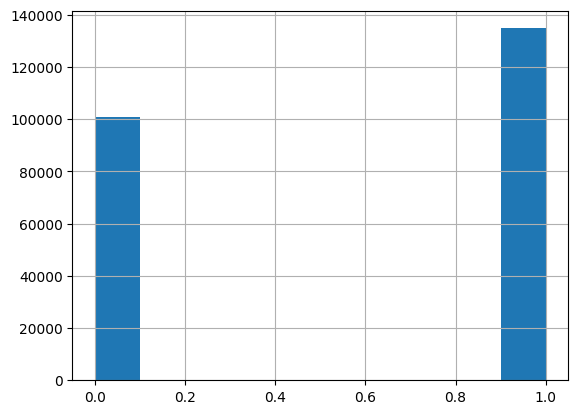

In [3]:
display(dataset["Phishing?"].value_counts())
# quality_num_bins = np.sort(dataset["label
#"].unique()) # Num bins = Num of unique target values
dataset["Phishing?"].hist()

In [4]:
# --- REPLACEMENT START ---
X = dataset.drop(columns="Phishing?", inplace=False)
y = dataset["Phishing?"]

# Use 50 Phishing samples for test, resulting in 50,000 Legitimate samples (1000:1)
url_train_x, url_test_x, url_train_y, url_test_y = get_imbalanced_test_split(X, y, test_phish_count=50, ratio=1000)

# For compatibility with your code, map the 'val' variables to 'test' 
# (Logistic Regression usually doesn't need a separate validation set unless you do grid search)
url_val_x = url_test_x
url_val_y = url_test_y
# --- REPLACEMENT END ---

Creating 1000:1 Test Split...
Test Set: 50 Phishing, 50000 Legitimate (Total: 50050)


In [4]:
url_train_x = url_train.drop(columns="Phishing?", inplace=False)
url_train_y = url_train["Phishing?"]

url_val_x = url_val.drop(columns="Phishing?", inplace=False)
url_val_y = url_val["Phishing?"]

url_test_x = url_test.drop(columns="Phishing?", inplace=False)
url_test_y = url_test["Phishing?"]

Training läuft auf: cuda
Starte Training für 500 Epochen...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     50000
           1       0.00      0.00      0.00        50

    accuracy                           1.00     50050
   macro avg       0.50      0.50      0.50     50050
weighted avg       1.00      1.00      1.00     50050

--- Ergebnisse Logistic Regression PhiUSIIL (Training) ---
Zeit: 6.62s | GPU-Last: 30.5%
VRAM (System): 1909.36 MB | VRAM (Torch): 63.28 MB


{'model': 'Logistic Regression PhiUSIIL',
 'task': 'Training',
 'time_sec': 6.62,
 'ram_mb': 1519.77,
 'vram_mb': 1909.36,
 'torch_vram_mb': 63.28,
 'cpu_percent': 127.8,
 'gpu_util_percent': 30.5}

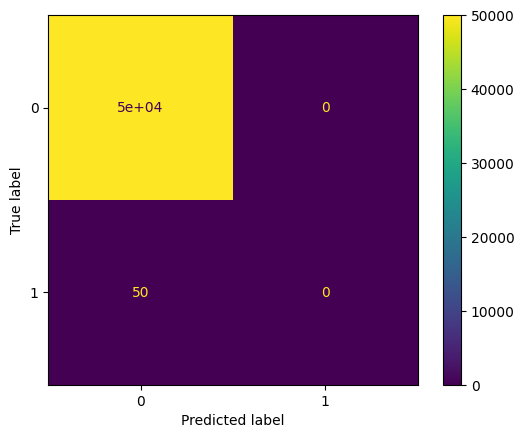

In [5]:
# --- LOGISTIC REGRESSION MIT GPU (PYTORCH) ---
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from benchmark import PerformanceMonitor

# Monitor starten
monitor = PerformanceMonitor("Logistic Regression PhiUSIIL")
monitor.start_measurement()

# 1. GPU Setup prüfen
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training läuft auf: {device}")

# 2. PyTorch Model Definition (Wrapper, der sich wie sklearn verhält)
class GPULogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(GPULogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        return torch.sigmoid(self.linear(x))

    # Hilfsfunktion, um sklearn-API nachzubauen
    def fit(self, X, y, epochs=100, lr=0.01, batch_size=4096):
        self.to(device)
        self.train()
        
        # Daten zu Tensoren konvertieren
        # .values nutzen, falls es Pandas Dataframes sind
        X_np = X.values if hasattr(X, 'values') else X
        y_np = y.values if hasattr(y, 'values') else y
        
        X_tensor = torch.tensor(X_np, dtype=torch.float32).to(device)
        y_tensor = torch.tensor(y_np, dtype=torch.float32).view(-1, 1).to(device)
        
        criterion = nn.BCELoss()
        optimizer = optim.Adam(self.parameters(), lr=lr)
        
        # Training Loop (Mini-Batch)
        num_samples = X_tensor.shape[0]
        num_batches = int(np.ceil(num_samples / batch_size))
        
        print(f"Starte Training für {epochs} Epochen...")
        for epoch in range(epochs):
            # Shuffle indices
            indices = torch.randperm(num_samples, device=device)
            
            for i in range(num_batches):
                start = i * batch_size
                end = min(start + batch_size, num_samples)
                batch_idx = indices[start:end]
                
                optimizer.zero_grad()
                outputs = self.forward(X_tensor[batch_idx])
                loss = criterion(outputs, y_tensor[batch_idx])
                loss.backward()
                optimizer.step()
                
    def predict(self, X):
        self.eval()
        with torch.no_grad():
            probs = self.predict_proba(X)[:, 1]
            return (probs >= 0.5).astype(int)

    def predict_proba(self, X):
        self.eval()
        X_np = X.values if hasattr(X, 'values') else X
        X_tensor = torch.tensor(X_np, dtype=torch.float32).to(device)
        
        with torch.no_grad():
            outputs = self.forward(X_tensor)
            probs = outputs.cpu().numpy().flatten()
            
        # Formatieren wie sklearn: [[prob_0, prob_1], ...]
        return np.vstack(((1 - probs), probs)).T

# 3. Modell initialisieren und trainieren
input_dim = url_train_x.shape[1]
log_reg = GPULogisticRegression(input_dim)

# Hyperparameter anpassen falls nötig (batch_size erhöht für GPU-Effizienz)
log_reg.fit(url_train_x, url_train_y, epochs=500, lr=0.001, batch_size=16384)

# 4. Validierung
wine_val_y_pred = log_reg.predict(url_val_x)
ClassPrintMetrics(url_val_y, wine_val_y_pred)

monitor.end_measurement(task_name="Training")

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# --- 5. INFERENZ & EVALUIERUNG ---
print("Starte Inferenz (gesamtes Testset)...")
monitor.start_measurement()

# 1. Vorhersage (Inferenz)
# Deine Klasse kümmert sich intern um .to(device) und .cpu()
# predict_proba gibt [[prob_0, prob_1], ...] zurück, wir brauchen Spalte 1
y_scores = log_reg.predict_proba(url_test_x)[:, 1]

# 2. Ground Truth (Echte Labels)
# Sicherstellen, dass es ein Numpy Array ist
y_true = url_test_y.values if hasattr(url_test_y, 'values') else url_test_y

# 3. Binäre Vorhersagen (Threshold 0.5)
y_pred_binary = (y_scores > 0.5).astype(int)

# --- METRIKEN BERECHNEN ---
# 1. Accuracy
acc = accuracy_score(y_true, y_pred_binary)
# 2. Precision
prec = precision_score(y_true, y_pred_binary, zero_division=0)
# 3. Recall
rec = recall_score(y_true, y_pred_binary, zero_division=0)
# 4. F1 Score
f1 = f1_score(y_true, y_pred_binary, zero_division=0)
# 5. AUC
auc = roc_auc_score(y_true, y_scores)

# 6. False Positive Rate (FPR)
# Confusion Matrix: tn, fp, fn, tp
tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0

# Ergebnisse zusammenpacken
metrics_dict = {
    "accuracy": round(acc, 4),
    "precision": round(prec, 4),
    "recall": round(rec, 4),
    "f1_score": round(f1, 4),
    "auc": round(auc, 4),
    "fpr": round(fpr, 4)
}

# An Monitor übergeben
monitor.end_measurement(task_name="Inferenz", extra_metrics=metrics_dict)

Starte Inferenz (gesamtes Testset)...
--- Ergebnisse Logistic Regression PhiUSIIL (Inferenz) ---
Zeit: 0.1011s | GPU-Last: 0.0%
VRAM (System): 1835.61 MB | VRAM (Torch): 26.18 MB


{'model': 'Logistic Regression PhiUSIIL',
 'task': 'Inferenz',
 'time_sec': 0.1011,
 'ram_mb': 1533.52,
 'vram_mb': 1835.61,
 'torch_vram_mb': 26.18,
 'cpu_percent': 630.7,
 'gpu_util_percent': 0.0,
 'accuracy': 0.999,
 'precision': 0.0,
 'recall': 0.0,
 'f1_score': 0.0,
 'auc': 0.1866,
 'fpr': np.float64(0.0)}